# Modelling Antibiotics Resistance through virtual simulations
authors: Talhah Peerbhai (talhah@cmu.edu), Hanna Qasim (hqasim@andrew.cmu.edu)

In [7]:
# Run this to initialize the model
import importlib
import seaborn as sns
import pandas as pd
# Due to the nature of jupyter it doesn't take into account the code outside changing unless kernel restarted
# this is a workaround as per https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
imported_module = importlib.import_module("simulation_model.simulation_model")
importlib.reload(imported_module)
from simulation_model.simulation_model import *

params = {
    # Environmental parameters
    "width": 200,
    "height": 200,
    "diffusion_coefficient": 0.1,
    # Bacterium parameters
    "num_agents": 10,
    "uptake_rate": 0.1,
    "uptake_rate_antibiotic": 0.1,
    "biomass_threshold": 10,
    "initial_size": 10,
    "initial_biomass": 0.1,
    "lag_phase": 66,
}

model = SimModel(params)

/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:77: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",self.width,self.height,default_value=0)


### View Nutrient distribution

Currently there are 5022.96426868583 nutrients


[Text(0.5, 1.0, 'Nutrient distribution')]

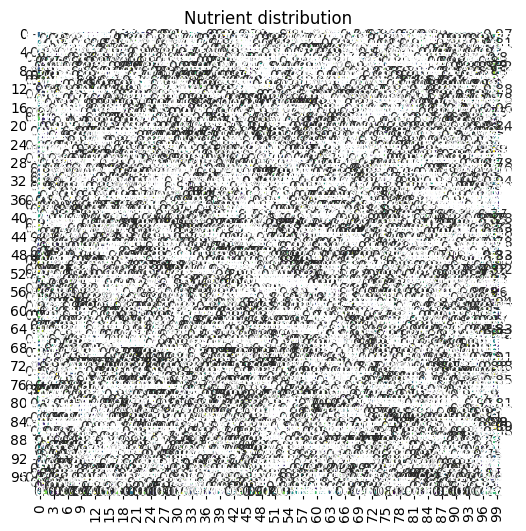

In [3]:
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]

print(f"Currently there are {amount} nutrients")
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(6, 6)
g.set(title="Nutrient distribution")

### View Agent distribution

[Text(0.5, 1.0, 'Agent Distribution')]

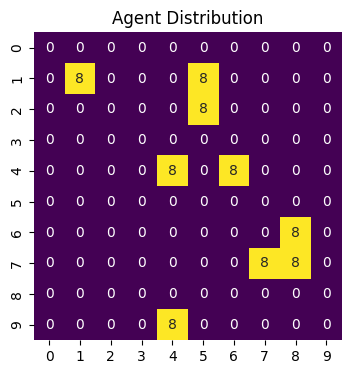

In [59]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
f = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
f.figure.set_size_inches(4, 4)
f.set(title="Agent Distribution")

### Step Through model

In [8]:
for _ in range(10000):
    model.step()